<a href="https://colab.research.google.com/github/eunicebalicanta/stock-prediction-sentiment/blob/main/stock_trend_prediction_news_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Stock Market Trends with News Sentiment Analysis


# 1. Data Collection

In [ ]:
# @title Install Libraries
# Install data manipulation libraries
!pip install pandas
!pip install numpy
!pip install datetime
!pip install json_normalize

# Install data visualization libraries
!pip install matplotlib
!pip install seaborn
!pip install plotly

# Install news and finance APIs
!pip install newsapi-python
!pip install --upgrade yfinance
!pip install mplfinance

# Install natural language processing libraries
!pip install nltk
!pip install vaderSentiment
!pip install textblob
!pip install regex

# Install other machine learning and statistics libraries
!pip install scikit-learn
!pip install scipy
!pip install tensorflow
!pip install keras
!pip install pmdarima
!pip install statsmodels

print("All libraries installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.0 MB/s eta 0:00:00
All libraries installed


In [ ]:
# @title Import Libraries
# Import data manipulation libraries
import pandas as pd
import numpy as np
import datetime as dt
import requests
import json
import json_normalize

# Import data visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import seaborn as sns
import plotly as py
import plotly.express as px

# Import news and finance APIs
from newsapi import NewsApiClient
import yfinance as yf
import mplfinance as mpf

# Import natural language proccessing libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import regex as re

# Import machine learning and statistics libraries
import sklearn as sk
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
import scipy as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# For Jupyer Notebook:
# %matplotlib inline

print("All libraries imported")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


All libraries imported


In [ ]:
# @title Retrieve Stock Information and Data
# Function for retrieving ticker symbol and company name
def get_company_name(symbol):
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        return info.get('longName', "Ticker name not found")
    except ValueError as ve:
        print(f"Value Error: {ve}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# Input to enter ticker symbol
ticker_symbol = input("Enter the stock ticker symbol: ").strip().upper()

if not ticker_symbol:
    print("Ticker symbol cannot be empty.")
else:
    company_name = get_company_name(ticker_symbol)

if company_name:
    print(f"The company name for ticker symbol '{ticker_symbol}' is '{company_name}'")
else:
    print("Company symbol not found or there was an error.")

Enter the stock ticker symbol: LXRX
The company name for ticker symbol 'LXRX' is 'Lexicon Pharmaceuticals, Inc.'


In [ ]:
ticker = yf.Ticker(ticker_symbol)
print(f"{company_name} Information:")
ticker.info

Lexicon Pharmaceuticals, Inc. Information:


{'address1': '2445 Technology Forest Boulevard',
 'address2': '11th Floor',
 'city': 'The Woodlands',
 'state': 'TX',
 'zip': '77381',
 'country': 'United States',
 'phone': '281 863 3000',
 'fax': '281 863 8088',
 'website': 'https://www.lexpharma.com',
 'industry': 'Biotechnology',
 'industryKey': 'biotechnology',
 'industryDisp': 'Biotechnology',
 'sector': 'Healthcare',
 'sectorKey': 'healthcare',
 'sectorDisp': 'Healthcare',
 'longBusinessSummary': 'Lexicon Pharmaceuticals, Inc., a biopharmaceutical company, focuses on the discovery, development, and commercialization of pharmaceutical products. Its orally-delivered small molecule drug candidates under development comprise Sotagliflozin that completed Phase III clinical trials for the for the treatment of heart failure and type 1 diabetes; and LX9211, which is in Phase II clinical development for the treatment of neuropathic pain and LX2761, which is in Phase I clinical development for gastrointestinal tract. Lexicon Pharmaceutica

In [ ]:
# Return date from today and 30 days ago
today = dt.date.today()
days_ago = today - dt.timedelta(days=30)
end = dt.date.today()
end = end.strftime('%Y-%m-%d')
start = days_ago.strftime('%Y-%m-%d')

print("Beginning and End Date for Information Retrieval:")
print(f"Date from 30 Days Ago: {start}")
print(f"Today's Date: {end}")

Beginning and End Date for Information Retrieval:
Date from 30 Days Ago: 2024-07-02
Today's Date: 2024-08-01


In [ ]:
# Retrieve Open-High-Low-Close Data from Yahoo Finance
stock_df = ticker.history(period="1mo")
stock_df.reset_index(inplace=True)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1, inplace=True)
stock_df.head()

,Date,Open,High,Low,Close
0,2024-07-01 00:00:00-04:00,1.68,1.77,1.66,1.68
1,2024-07-02 00:00:00-04:00,1.69,1.71,1.60,1.60
2,2024-07-03 00:00:00-04:00,1.62,1.66,1.59,1.66
3,2024-07-05 00:00:00-04:00,1.66,1.67,1.61,1.67
4,2024-07-08 00:00:00-04:00,1.67,1.71,1.58,1.60


In [ ]:
# @title Retrieve Relevant News Data
# Query news API to fetch relevant articles to the company
news_api_key = 'f9397fe9af6d484cba729965088792f6'

url = f"https://newsapi.org/v2/everything?q={company_name}&from={start}&to={end}&sortBy=relevancy&apiKey={news_api_key}"
response = requests.get(url)
news_api_data = response.json()
news_api_data

{'status': 'ok',
 'totalResults': 13,
 'articles': [{'source': {'id': None, 'name': 'Yahoo Entertainment'},
   'author': 'editorial-team@simplywallst.com (Simply Wall St)',
   'title': "Private equity firms account for 48% of Lexicon Pharmaceuticals, Inc.'s (NASDAQ:LXRX) ownership, while individual investors account for 33%",
   'description': 'Key Insights Significant control over Lexicon Pharmaceuticals by private equity firms implies that the general public...',
   'url': 'https://finance.yahoo.com/news/private-equity-firms-account-48-111137154.html',
   'urlToImage': 'https://media.zenfs.com/en/simply_wall_st__316/2b615bb0216a492e754128412857f305',
   'publishedAt': '2024-07-11T11:11:37Z',
   'content': 'Key Insights\r\n<ul><li>Significant control over Lexicon Pharmaceuticals by private equity firms implies that the general public has more power to influence management and governance-related decisions\r… [+5508 chars]'},
  {'source': {'id': None, 'name': 'Investing.com'},
   'autho

In [ ]:
# Save the news data into a JSON file
with open('news_api_data.json', 'w') as file:
    json.dump(news_api_data, file)

print("Data saved to 'news_api_data.json'")

Data saved to 'news_api_data.json'


In [ ]:
# Save news results into a dataframe
news_df = pd.json_normalize(news_api_data['articles'])
news_df.rename(columns={
    'source.id': 'source_id',
    'source.name': 'source_name',
    'publishedAt': 'date',
    'urlToImage': 'image_url'
}, inplace=True)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df['date'] = news_df['date'].dt.date
news_df

,author,title,description,url,image_url,date,content,source_id,source_name
0,editorial-team@simplywallst.com (Simply Wall St),Private equity firms account for 48% of Lexico...,Key Insights Significant control over Lexicon ...,https://finance.yahoo.com/news/private-equity-...,https://media.zenfs.com/en/simply_wall_st__316...,2024-07-11,Key Insights\r\n<ul><li>Significant control ov...,None,Yahoo Entertainment
1,Investing.com,Lexicon Pharmaceuticals appoints new CEO and b...,Lexicon Pharmaceuticals appoints new CEO and b...,https://www.investing.com/news/company-news/le...,https://i-invdn-com.investing.com/news/World_N...,2024-07-08,"Lexicon Pharmaceuticals , Inc. (NASDAQ:LXRX), ...",None,Investing.com
2,MarketBeat News,Lexicon Pharmaceuticals (NASDAQ:LXRX) Shares C...,"Lexicon Pharmaceuticals, Inc. (NASDAQ:LXRX – G...",https://www.etfdailynews.com/2024/07/24/lexico...,https://www.americanbankingnews.com/wp-content...,2024-07-24,"Lexicon Pharmaceuticals, Inc. (NASDAQ:LXRX – G...",None,ETF Daily News
3,Investing.com,Lexicon Pharmaceuticals to Host Second Quarter...,Lexicon Pharmaceuticals to Host Second Quarter...,https://www.investing.com/news/press-releases/...,https://i-invdn-com.investing.com/news/interna...,2024-07-25,"THE WOODLANDS, Texas, July 25, 2024 (GLOBE NEW...",None,Investing.com
4,MarketBeat News,Lexicon Pharmaceuticals (NASDAQ:LXRX) Receives...,HC Wainwright reissued their buy rating on sha...,https://www.etfdailynews.com/2024/07/17/lexico...,https://www.americanbankingnews.com/wp-content...,2024-07-17,HC Wainwright reissued their buy rating on sha...,None,ETF Daily News
5,MarketBeat News,BNP Paribas Financial Markets Boosts Stake in ...,BNP Paribas Financial Markets increased its po...,https://www.etfdailynews.com/2024/07/27/bnp-pa...,https://www.americanbankingnews.com/wp-content...,2024-07-27,BNP Paribas Financial Markets increased its po...,None,ETF Daily News
6,MarketBeat News,Lexicon Pharmaceuticals (NASDAQ:LXRX) Lifted t...,StockNews.com upgraded shares of Lexicon Pharm...,https://www.etfdailynews.com/2024/07/10/lexico...,https://www.americanbankingnews.com/wp-content...,2024-07-10,StockNews.com upgraded shares of Lexicon Pharm...,None,ETF Daily News
7,Investing.com,Lexicon Board of Directors Appoints Mike Exton...,Lexicon Board of Directors Appoints Mike Exton...,https://www.investing.com/news/press-releases/...,https://i-invdn-com.investing.com/news/World_N...,2024-07-08,"THE WOODLANDS, Texas, July 08, 2024 (GLOBE NEW...",None,Investing.com
8,"Lexicon Pharmaceuticals, Inc.",Lexicon Pharmaceuticals to Host Second Quarter...,"THE WOODLANDS, Texas, July 25, 2024 (GLOBE NEW...",https://www.globenewswire.com/news-release/202...,https://ml.globenewswire.com/Resource/Download...,2024-07-25,"THE WOODLANDS, Texas, July 25, 2024 (GLOBE NEW...",None,GlobeNewswire
9,"Lexicon Pharmaceuticals, Inc.",Lexicon Board of Directors Appoints Mike Exton...,Jeff Wade Named President and Chief Operating ...,https://www.globenewswire.com/news-release/202...,https://ml.globenewswire.com/Resource/Download...,2024-07-08,"THE WOODLANDS, Texas, July 08, 2024 (GLOBE NEW...",None,GlobeNewswire


In [ ]:
# Sort date values and drop duplicates in the "description" column
news_df['description']=news_df['description'].astype(str)
news_df.drop_duplicates('description')
news_df = news_df.sort_values(['date'])
news_df['date'].describe()

,date
count,13
unique,9
top,2024-07-08
freq,3


In [ ]:
# Group dataframe by news sources
source_data = pd.DataFrame(news_df.groupby('source_name').count())
source_data.reset_index(inplace=True)
source_data = source_data[source_data['source_name'] != '[Removed]']
source_data = source_data[source_data['source_name'] != '']
source_data = source_data[source_data['source_name'] != 'None']

In [ ]:
# Create a dataframe by news source names
source_data.set_index('source_name', inplace=True)
source_data

,author,title,description,url,image_url,date,content,source_id
source_name,,,,,,,,
ETF Daily News,4,4,4,4,4,4,4,0
GlobeNewswire,4,4,4,4,4,4,4,0
Investing.com,4,4,4,4,4,4,4,0
Yahoo Entertainment,1,1,1,1,1,1,1,0


<ipython-input-13-4a642746ecdf>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x = source_data['description'], y = source_data.index, palette='husl')


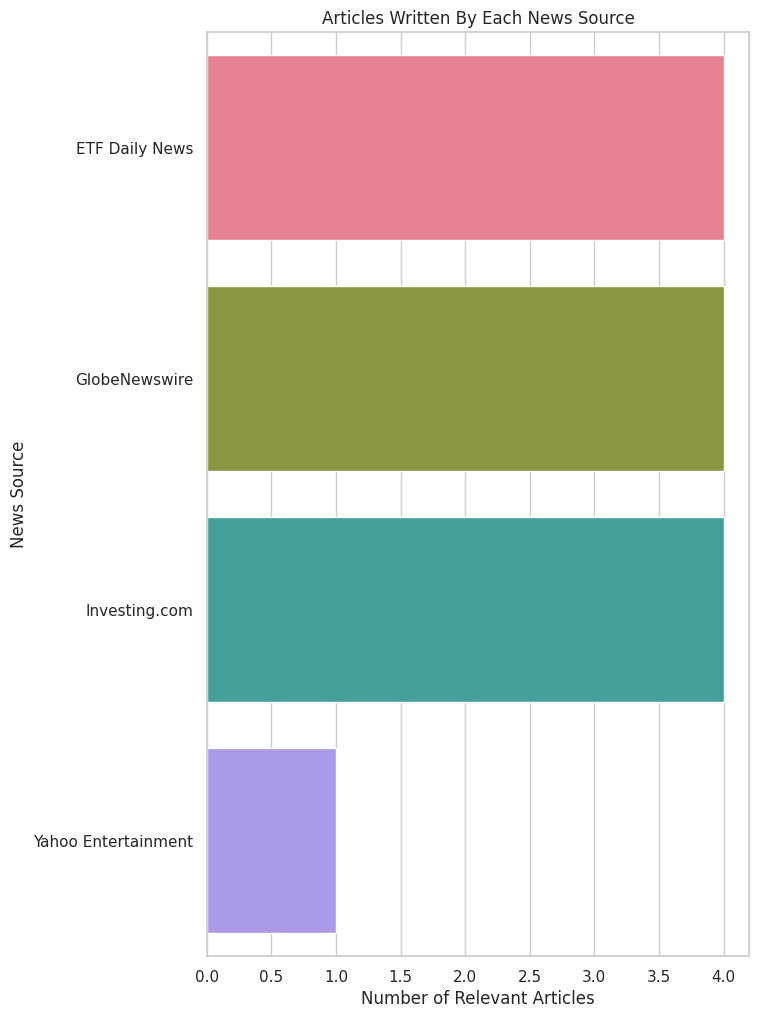

In [ ]:
# Plot the number of relevant news articles written by each source
plt.figure(figsize =(7,12))
sns.set(style = 'whitegrid')

sns.barplot( x = source_data['description'], y = source_data.index, palette='husl')
plt.xlabel('Number of Relevant Articles')
plt.ylabel('News Source')
plt.title('Articles Written By Each News Source')
plt.savefig('Articles_Written_By_Source.png')
plt.show()

In [ ]:
# Create a dataframe with news article unique dates
news_df['description'][pd.isnull(news_df['description']) == True]
date_data = pd.DataFrame(news_df.groupby('date').count())
date_data.reset_index(inplace=True)
date_data.head()

,date,author,title,description,url,image_url,content,source_id,source_name
0,2024-07-08,3,3,3,3,3,3,0,3
1,2024-07-10,1,1,1,1,1,1,0,1
2,2024-07-11,1,1,1,1,1,1,0,1
3,2024-07-15,1,1,1,1,1,1,0,1
4,2024-07-17,1,1,1,1,1,1,0,1


In [ ]:
# Remove rows with the default date value "1970-01-01"
date_data['date'] = pd.to_datetime(date_data['date'])
date_data = date_data[date_data.loc[:, 'date'].dt.year != 1970]
date_data.set_index('date', inplace=True)
date_data.head()

,author,title,description,url,image_url,content,source_id,source_name
date,,,,,,,,
2024-07-08,3,3,3,3,3,3,0,3
2024-07-10,1,1,1,1,1,1,0,1
2024-07-11,1,1,1,1,1,1,0,1
2024-07-15,1,1,1,1,1,1,0,1
2024-07-17,1,1,1,1,1,1,0,1


<ipython-input-16-f83de2f17be8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  articles_time_plot = sns.barplot( x = date_data.index , y = date_data['description'], palette='hls')


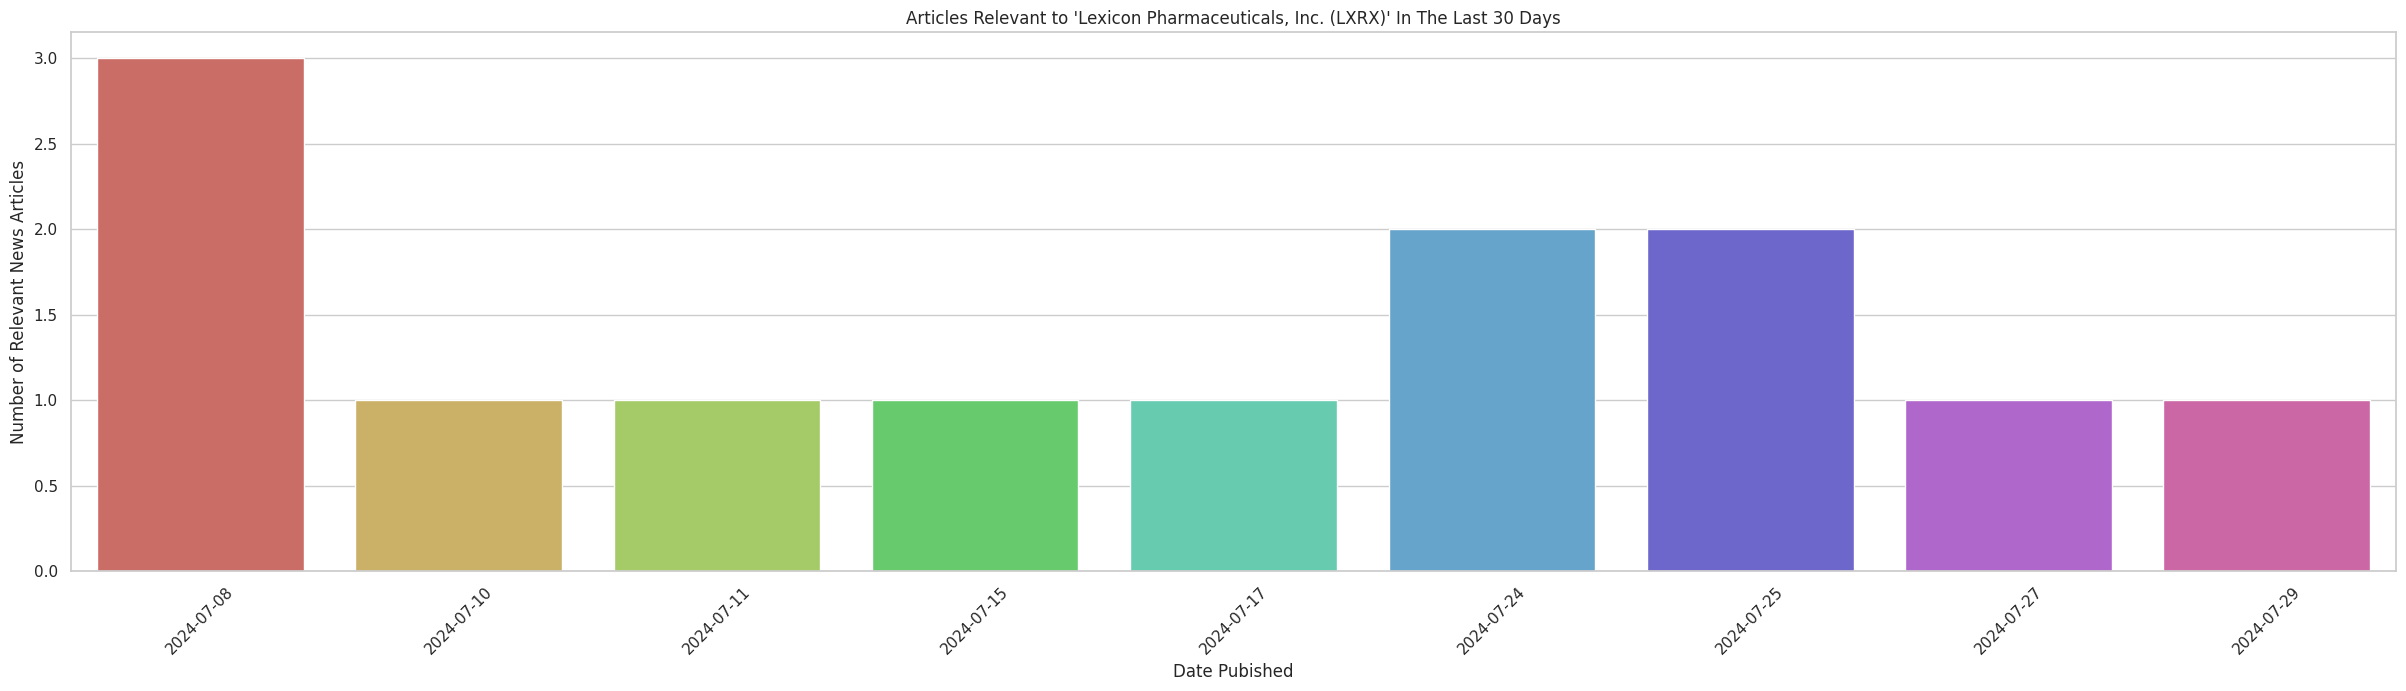

In [ ]:
# Plot the number of news articles relevant to company in the past month
plt.figure(figsize =(30,7))
articles_time_plot = sns.barplot( x = date_data.index , y = date_data['description'], palette='hls')

# Set titles and labels
articles_time_plot.set(xlabel = 'Date Pubished', ylabel = 'Number of Relevant News Articles')
plt.xticks(rotation=45)
plt.title(f"Articles Relevant to '{company_name} ({ticker_symbol})' In The Last 30 Days")

plt.savefig('Articles_30_Days.png')
plt.show()

In [ ]:
# Retrieve article description headers
news_df['description']= news_df['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
news_df = news_df[news_df['description'] != '[removed]']
news_df = news_df[news_df['description'] != 'none']
news_df = news_df[news_df['description'] != '']
news_df.head()

,author,title,description,url,image_url,date,content,source_id,source_name
1,Investing.com,Lexicon Pharmaceuticals appoints new CEO and b...,lexicon pharmaceuticals appoints new ceo and b...,https://www.investing.com/news/company-news/le...,https://i-invdn-com.investing.com/news/World_N...,2024-07-08,"Lexicon Pharmaceuticals , Inc. (NASDAQ:LXRX), ...",None,Investing.com
7,Investing.com,Lexicon Board of Directors Appoints Mike Exton...,lexicon board of directors appoints mike exton...,https://www.investing.com/news/press-releases/...,https://i-invdn-com.investing.com/news/World_N...,2024-07-08,"THE WOODLANDS, Texas, July 08, 2024 (GLOBE NEW...",None,Investing.com
9,"Lexicon Pharmaceuticals, Inc.",Lexicon Board of Directors Appoints Mike Exton...,jeff wade named president and chief operating ...,https://www.globenewswire.com/news-release/202...,https://ml.globenewswire.com/Resource/Download...,2024-07-08,"THE WOODLANDS, Texas, July 08, 2024 (GLOBE NEW...",None,GlobeNewswire
6,MarketBeat News,Lexicon Pharmaceuticals (NASDAQ:LXRX) Lifted t...,stocknews.com upgraded shares of lexicon pharm...,https://www.etfdailynews.com/2024/07/10/lexico...,https://www.americanbankingnews.com/wp-content...,2024-07-10,StockNews.com upgraded shares of Lexicon Pharm...,None,ETF Daily News
0,editorial-team@simplywallst.com (Simply Wall St),Private equity firms account for 48% of Lexico...,key insights significant control over lexicon ...,https://finance.yahoo.com/news/private-equity-...,https://media.zenfs.com/en/simply_wall_st__316...,2024-07-11,Key Insights\r\n<ul><li>Significant control ov...,None,Yahoo Entertainment


In [ ]:
# Retrieve word count for each description header
news_df['word_count'] = news_df['description'].apply(lambda x: len(str(x).split(" ")))
news_df[['description','word_count']].head()

,description,word_count
1,lexicon pharmaceuticals appoints new ceo and b...,8
7,lexicon board of directors appoints mike exton...,15
9,jeff wade named president and chief operating ...,16
6,stocknews.com upgraded shares of lexicon pharm...,41
0,key insights significant control over lexicon ...,16


In [ ]:
# Call stopwords function to ignore words such as "the"," "an," "as," "a," etc.
stop = stopwords.words('english')
news_df['stopwords'] = news_df['description'].apply(lambda x: len([x for x in x.split() if x in stop]))
news_df[['description','stopwords']].head()

,description,stopwords
1,lexicon pharmaceuticals appoints new ceo and b...,1
7,lexicon board of directors appoints mike exton...,3
9,jeff wade named president and chief operating ...,2
6,stocknews.com upgraded shares of lexicon pharm...,14
0,key insights significant control over lexicon ...,4


In [ ]:
# Show rows with numerical values
news_df['description'] = news_df['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
news_df['numerics'] = news_df['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
news_df['numerics'].head()

,numerics
1,0
7,0
9,0
6,0
0,0


In [ ]:
# Convert to lowercase, expand contractions, and remove special characters, extra spaces, and non-ASCII characters
def remove_non_A(s):
    return "".join(i for i in s if ord(i) < 128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [ ]:
# Create a dataframe with the dates for each unique description
description_df = news_df[['description','date']]
description_df.loc[:, 'description'] = description_df['description'].apply(remove_non_A)
description_df.head()

,description,date
1,lexicon pharmaceuticals appoints new ceo board...,2024-07-08
7,"lexicon board directors appoints mike exton, p...",2024-07-08
9,jeff wade named president chief operating offi...,2024-07-08
6,stocknews.com upgraded shares lexicon pharmace...,2024-07-10
0,key insights significant control lexicon pharm...,2024-07-11


In [ ]:
# Initialize lexicon-based anaysis using Vader Sentiment Analyzer to determine the presence of positive, negative, and neutral sentiments
analyzer = SentimentIntensityAnalyzer()

# Create empty lists to store sentiment scores
positive_scores = []
negative_scores = []
neutral_scores = []
compound_scores = []

# Loop through each description and calculate sentiment scores
for description in description_df['description']:
    sentiment = analyzer.polarity_scores(description)
    positive_scores.append(sentiment['pos'])
    negative_scores.append(sentiment['neg'])
    neutral_scores.append(sentiment['neu'])
    compound_scores.append(sentiment['compound'])

description_df.loc[:, 'positive'] = positive_scores
description_df.loc[:, 'negative'] = negative_scores
description_df.loc[:, 'neutral'] = neutral_scores
description_df.loc[:, 'compound'] = compound_scores

# Sort DataFrame by 'date' column in ascending order
description_df.sort_values(by='date', ascending=True)

<ipython-input-24-cfb939c0090e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  description_df.loc[:, 'positive'] = positive_scores
<ipython-input-24-cfb939c0090e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  description_df.loc[:, 'negative'] = negative_scores
<ipython-input-24-cfb939c0090e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,description,date,positive,negative,neutral,compound
1,lexicon pharmaceuticals appoints new ceo board...,2024-07-08,0.000,0.000,1.000,0.0000
7,"lexicon board directors appoints mike exton, p...",2024-07-08,0.000,0.000,1.000,0.0000
9,jeff wade named president chief operating offi...,2024-07-08,0.000,0.000,1.000,0.0000
6,stocknews.com upgraded shares lexicon pharmace...,2024-07-10,0.364,0.000,0.636,0.8750
0,key insights significant control lexicon pharm...,2024-07-11,0.141,0.000,0.859,0.2023
10,new published data highlights potential cost-s...,2024-07-15,0.271,0.213,0.516,0.2263
4,hc wainwright reissued buy rating shares lexic...,2024-07-17,0.228,0.000,0.772,0.7003
2,"lexicon pharmaceuticals, inc. (nasdaq:lxrx ge...",2024-07-24,0.222,0.000,0.778,0.7717
11,"dublin, july 24, 2024 (globe newswire) -- ""chr...",2024-07-24,0.000,0.000,1.000,0.0000
3,lexicon pharmaceuticals host second quarter 20...,2024-07-25,0.000,0.000,1.000,0.0000


## 2. Sentiment Analysis


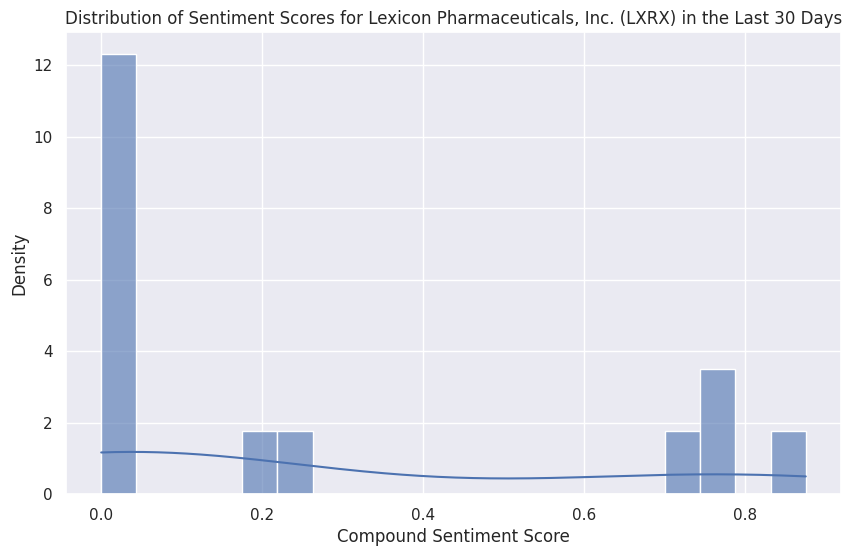

In [ ]:
# @title Visualize Sentiment Scores and OHLC Data
# Visualize the distribution of sentiment scores within the past 30 days
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(description_df['compound'], bins=20, kde=True, stat='density', alpha=0.6)
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Density')
plt.title(f"Distribution of Sentiment Scores for {company_name} ({ticker_symbol}) in the Last 30 Days")

plt.show()

In [ ]:
# Retrieve Open-High-Low-Close Data from Yahoo Finance with "Date" column indexed
stock_df = ticker.history(period="1mo")
stock_df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1, inplace=True)
stock_df.reset_index(inplace=True)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df
stock_df.head()

,Date,Open,High,Low,Close
0,2024-07-01 00:00:00-04:00,1.68,1.77,1.66,1.68
1,2024-07-02 00:00:00-04:00,1.69,1.71,1.60,1.60
2,2024-07-03 00:00:00-04:00,1.62,1.66,1.59,1.66
3,2024-07-05 00:00:00-04:00,1.66,1.67,1.61,1.67
4,2024-07-08 00:00:00-04:00,1.67,1.71,1.58,1.60


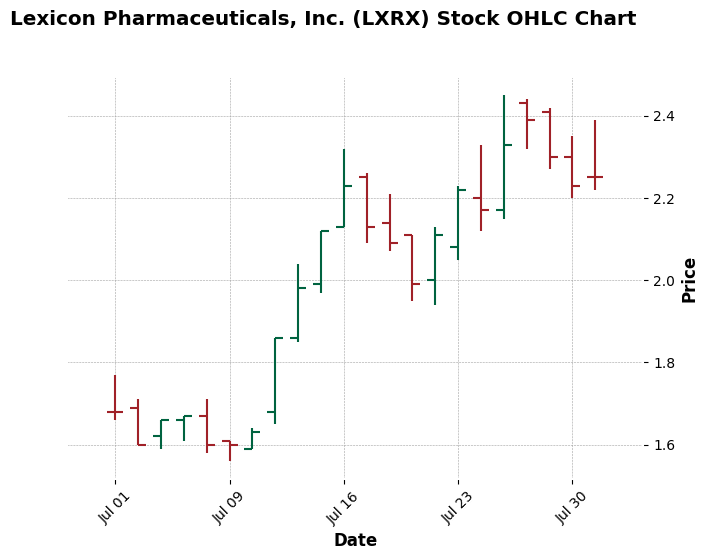

In [ ]:
# Create an Open-High-Low-Close Chart
stock_df.set_index('Date', inplace=True)
stock_df.index = pd.to_datetime(stock_df.index)

ohlc_title = f"{company_name} ({ticker_symbol}) Stock OHLC Chart"
ohlc_chart = mpf.plot(stock_df, type = 'ohlc', style = 'charles', title = ohlc_title, xlabel = 'Date', ylabel = 'Price')

In [ ]:
# Create a Dataframe with the "Close" and "Date" columns
close_df = pd.DataFrame(stock_df['Close'])
close_df.reset_index(inplace=True)
close_df['Date_Formatted'] = close_df['Date'].dt.strftime('%Y-%m-%d')
close_df

,Date,Close,Date_Formatted
0,2024-07-01 00:00:00-04:00,1.68,2024-07-01
1,2024-07-02 00:00:00-04:00,1.60,2024-07-02
2,2024-07-03 00:00:00-04:00,1.66,2024-07-03
3,2024-07-05 00:00:00-04:00,1.67,2024-07-05
4,2024-07-08 00:00:00-04:00,1.60,2024-07-08
5,2024-07-09 00:00:00-04:00,1.60,2024-07-09
6,2024-07-10 00:00:00-04:00,1.63,2024-07-10
7,2024-07-11 00:00:00-04:00,1.86,2024-07-11
8,2024-07-12 00:00:00-04:00,1.98,2024-07-12
9,2024-07-15 00:00:00-04:00,2.12,2024-07-15


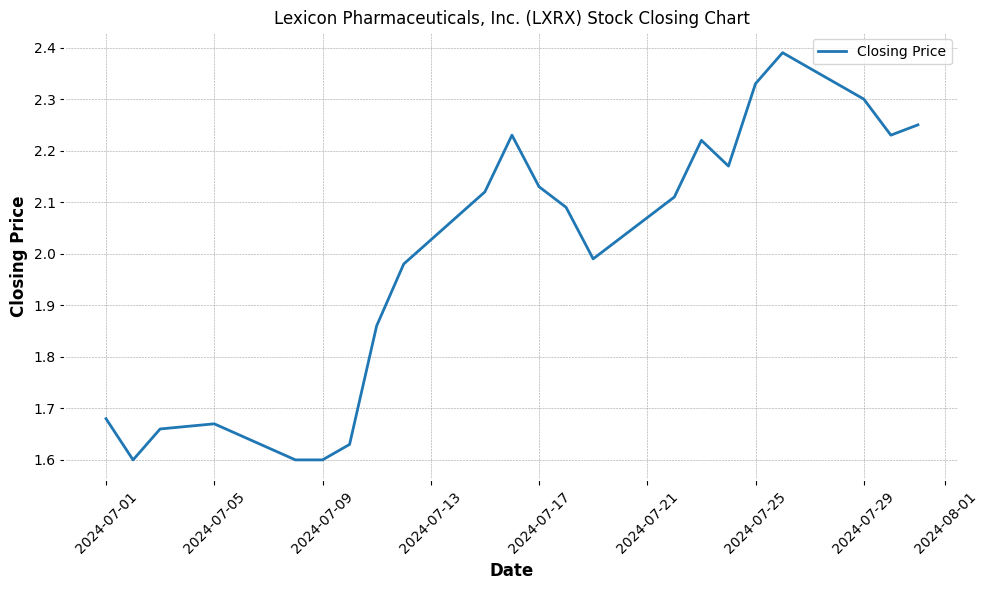

In [ ]:
# Plot the closing price data
close_title = f"{company_name} ({ticker_symbol}) Stock Closing Chart"
plt.figure(figsize=(10, 6))
plt.plot(close_df['Date'], close_df['Close'], label='Closing Price')

# Set plot title and labels
plt.title(close_title)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

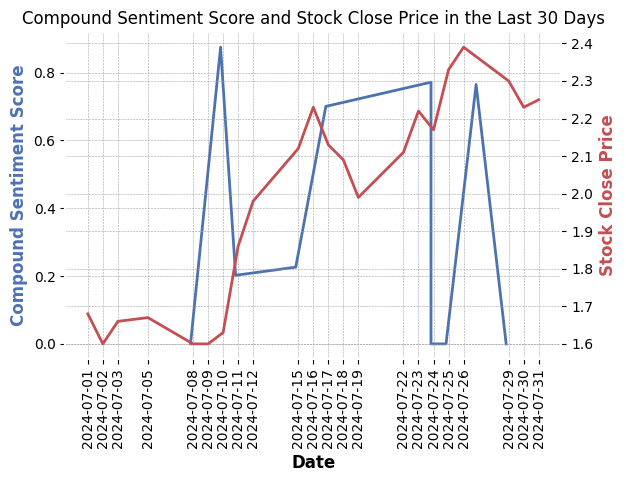

In [ ]:
# Ensure columns are numeric and drop NaNs
close_df['Close'] = pd.to_numeric(close_df['Close'], errors='coerce')
description_df.loc[:, 'compound'] = pd.to_numeric(description_df['compound'], errors='coerce')
close_df = close_df.dropna(subset=['Close'])
description_df = description_df.dropna(subset=['compound'])

# Plot with dual y-axes
fig, axis_1 = plt.subplots()
axis_2 = axis_1.twinx()

# Create the "Compound Sentiment Score" y-axis data
description_df.plot(x='date', y="compound", ax = axis_1, legend=False, color='b')

# Create the "Stock Close Price" y-axis data
close_df.plot(x='Date', y="Close", ax = axis_2, legend=False, color='r')

# Rotate x-axis labels and set the x-ticks
axis_1.set_xticks(close_df['Date'])
axis_1.set_xticklabels(close_df['Date'].dt.strftime('%Y-%m-%d'), rotation=90)
axis_1.set_xlabel("Date")

# Set labels and titles
axis_1.set_ylabel("Compound Sentiment Score", color='b')
axis_2.set_ylabel("Stock Close Price", color='r')
plt.title("Compound Sentiment Score and Stock Close Price in the Last 30 Days")

# Show the plot
plt.xticks(rotation=45)
plt.show()

## 3. Feature Engineering

In [ ]:
# @title Prepare Data for Prediction
# Normalize Close stock prices and compound sentiment scores
scaler_close = StandardScaler()
close_df['Close'] = scaler_close.fit_transform(close_df[['Close']])
scaler_compound = StandardScaler()
description_df['compound'] = scaler_compound.fit_transform(description_df[['compound']])

# Ensure dates are in datetime format
close_df['Date_Formatted'] = pd.to_datetime(close_df['Date_Formatted'])
description_df['date'] = pd.to_datetime(description_df['date'])

# Merge close_df and description_df
combined_df = pd.merge(close_df, description_df, left_on='Date_Formatted', right_on='date', how='inner')
combined_df.reset_index(drop=True, inplace=True)
combined_df['Date_Formatted'] = pd.to_datetime(combined_df['Date'], format='%Y-%m-%d')
combined_df.set_index('Date_Formatted', inplace=True)

print("DataFrame Columns:")
print(combined_df.columns)
combined_df.head()

DataFrame Columns:
Index(['Date', 'Close', 'description', 'date', 'positive', 'negative',
       'neutral', 'compound'],
      dtype='object')


,Date,Close,description,date,positive,negative,neutral,compound
Date_Formatted,,,,,,,,
2024-07-08 00:00:00-04:00,2024-07-08 00:00:00-04:00,-1.451365,lexicon pharmaceuticals appoints new ceo board...,2024-07-08,0.000,0.0,1.000,-0.785053
2024-07-08 00:00:00-04:00,2024-07-08 00:00:00-04:00,-1.451365,"lexicon board directors appoints mike exton, p...",2024-07-08,0.000,0.0,1.000,-0.785053
2024-07-08 00:00:00-04:00,2024-07-08 00:00:00-04:00,-1.451365,jeff wade named president chief operating offi...,2024-07-08,0.000,0.0,1.000,-0.785053
2024-07-10 00:00:00-04:00,2024-07-10 00:00:00-04:00,-1.340497,stocknews.com upgraded shares lexicon pharmace...,2024-07-10,0.364,0.0,0.636,1.737113
2024-07-11 00:00:00-04:00,2024-07-11 00:00:00-04:00,-0.490508,key insights significant control lexicon pharm...,2024-07-11,0.141,0.0,0.859,-0.201928


## 4. Model Development and Evaluation

In [ ]:
# @title Stock Trend Prediction using Long Short Term Memory (LSTM)
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[['compound', 'Close']])

# Create sequences
def create_sequences(df, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[i:i + seq_length, :])  # Features
        y.append(df[i + seq_length, 1])  # Target
    return np.array(X), np.array(y)

SEQ_LENGTH = 20
X, y = create_sequences(scaled_features, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM Model and callbacks
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.3, kernel_regularizer='l2'), input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Bidirectional(LSTM(units=100, dropout=0.3, kernel_regularizer='l2')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_split=0.1, callbacks=[early_stopping, model_checkpoint], verbose=1)

# Evaluate the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Calculate MSE and RMSE for Training Data
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)

# Calculate MSE and RMSE for Testing Data
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training MSE: 0.2228
Training RMSE: 0.4720
Test MSE: 0.0659
Test RMSE: 0.2568


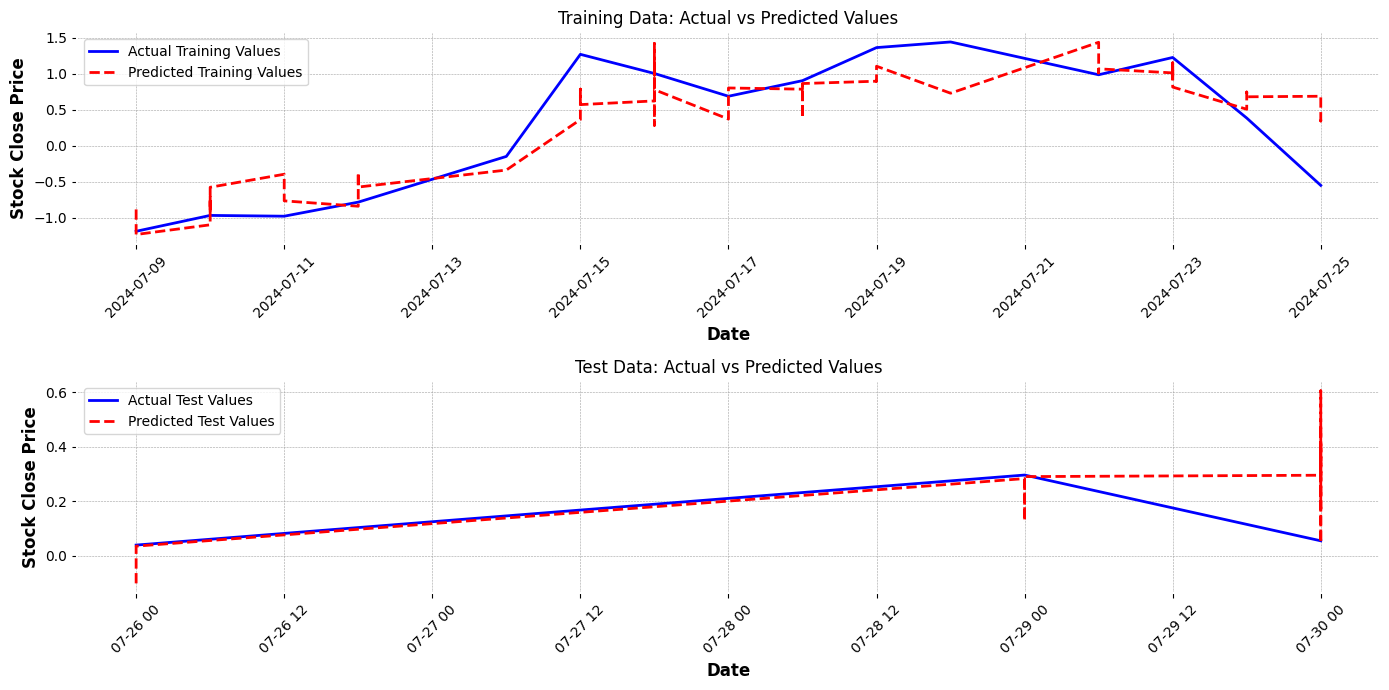

In [ ]:
# Reshape y_train and y_test
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse transform the actual values and predictions
scaler_close = StandardScaler().fit(combined_df[['Close']])
y_train_original = scaler_close.inverse_transform(y_train_reshaped)
y_test_original = scaler_close.inverse_transform(y_test_reshaped)
train_predictions_original = scaler_close.inverse_transform(train_predictions)
test_predictions_original = scaler_close.inverse_transform(test_predictions)

# Extract dates
train_dates = combined_df.index[SEQ_LENGTH:SEQ_LENGTH + len(y_train)]
test_dates = combined_df.index[len(y_train) + SEQ_LENGTH:len(y_train) + SEQ_LENGTH + len(y_test)]

# Plot results
plt.figure(figsize=(14, 7))

# Plot Training Data
plt.subplot(2, 1, 1)
plt.plot(train_dates, y_train_original, label='Actual Training Values', color='blue')
plt.plot(train_dates, train_predictions_original, label='Predicted Training Values', color='red', linestyle='--')
plt.title('Training Data: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Close Price')
plt.legend()
plt.xticks(rotation=45)

# Plot Test Data
plt.subplot(2, 1, 2)
plt.plot(test_dates, y_test_original, label='Actual Test Values', color='blue')
plt.plot(test_dates, test_predictions_original, label='Predicted Test Values', color='red', linestyle='--')
plt.title('Test Data: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Close Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Determine mean MSE through K-Fold Cross Validation
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    predictions = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, predictions))

mean_mse = np.mean(mse_scores)
print(f"Mean MSE from TimeSeriesSplit: {mean_mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean MSE from TimeSeriesSplit: 0.5987213911312252


In [ ]:
# @title Stock Trend Prediction using Autoregressive Integrated Moving Average (ARIMA)
combined_df[['compound', 'Close']] = scaler.fit_transform(combined_df[['compound', 'Close']])

# # Create a composite feature by adding 'compound' and 'Close'
combined_df['Composite'] = combined_df['compound'] + combined_df['Close']

# Train and test sets
train_size = int(len(combined_df) * 0.8)
train_series = combined_df['Composite'][:train_size]
test_series = combined_df['Composite'][train_size:]

# Find the best ARIMA parameters
model_auto = auto_arima(train_series, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)
print(model_auto.summary())

# Fit and test ARIMA model
best_order = model_auto.order
model = ARIMA(train_series, order=best_order)
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test_series))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=224.790, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=213.370, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=210.493, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=222.807, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=208.820, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=209.809, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=210.451, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=211.466, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.176 seconds
                               SARIMAX Results         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [ ]:
# Evaluate the model
mse = mean_squared_error(test_series, forecast)
test_rmse = np.sqrt(mse)
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test MSE: 0.8643
Test RMSE: 0.9297


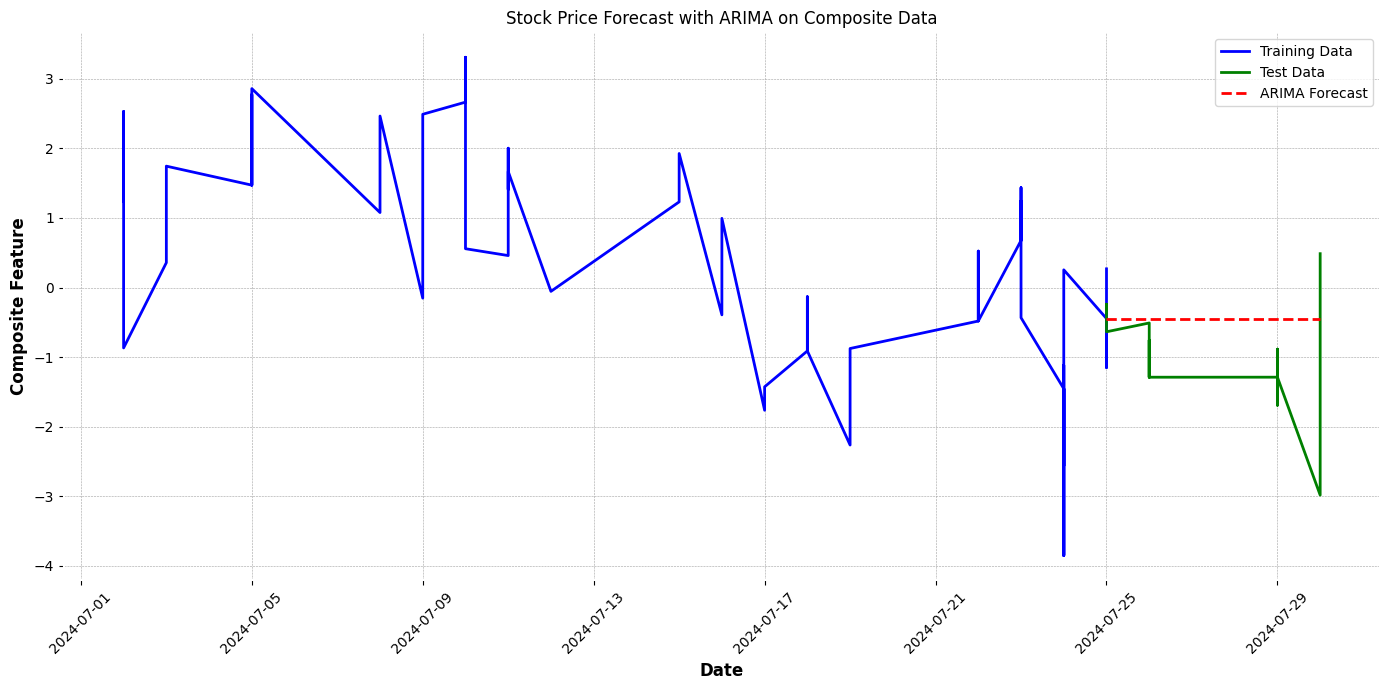

In [ ]:
# Plot results
plt.figure(figsize=(14, 7))

plt.plot(train_series.index, train_series, label='Training Data', color='blue')
plt.plot(test_series.index, test_series, label='Test Data', color='green')
plt.plot(test_series.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')

plt.title('Stock Price Forecast with ARIMA on Composite Data')
plt.xlabel('Date')
plt.ylabel('Composite Feature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# @title Stock Trend Prediction using Linear Regression
# Prepare the features and target, and drop rows with NaN values
combined_df['Target'] = combined_df['Close'].shift(-1)  # Shift Close column to create a target for the next day
data = combined_df.dropna(subset=['Target'])

# Features and target
X = data[['compound', 'Close']]
y = data['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

In [ ]:
# Evaluate the model
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training MSE: 0.0772
Training RMSE: 0.2778
Test MSE: 0.0131
Test RMSE: 0.1146


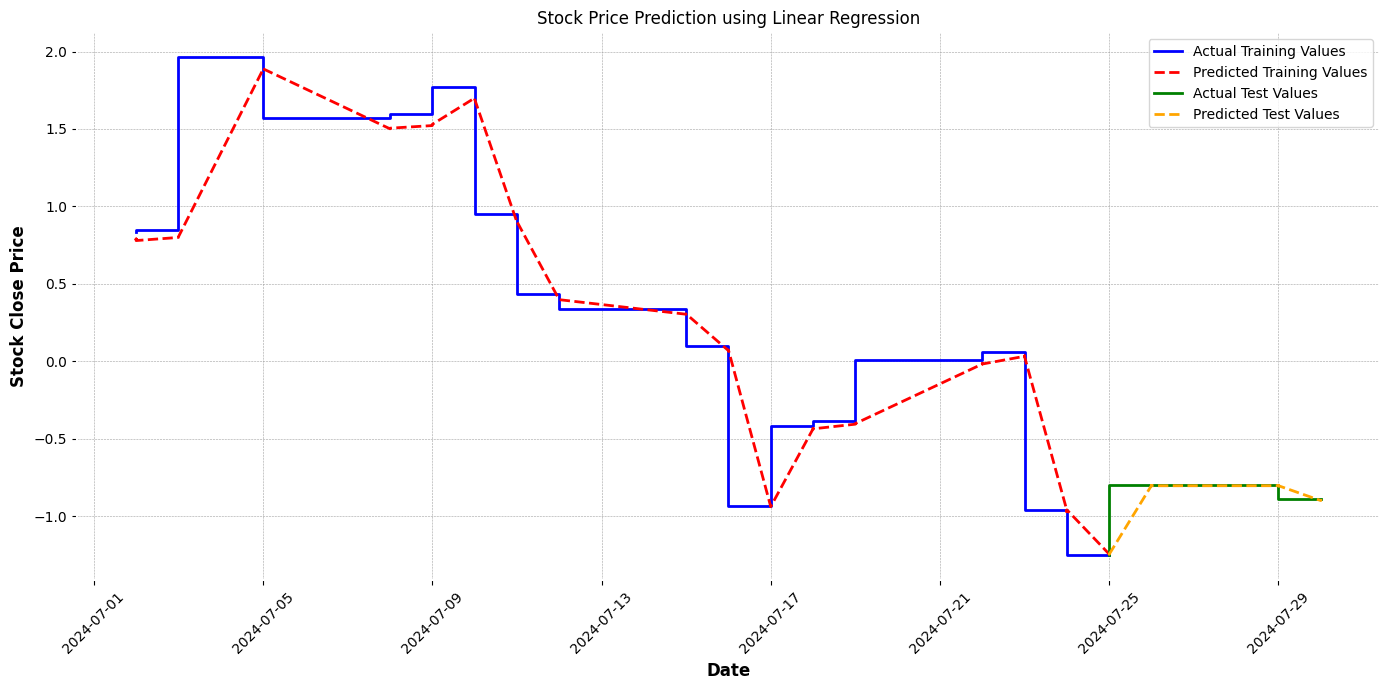

In [ ]:
# Plot results
plt.figure(figsize=(14, 7))

plt.plot(y_train.index, y_train, label='Actual Training Values', color='blue')
plt.plot(y_train.index, train_predictions, label='Predicted Training Values', color='red', linestyle='--')

plt.plot(y_test.index, y_test, label='Actual Test Values', color='green')
plt.plot(y_test.index, test_predictions, label='Predicted Test Values', color='orange', linestyle='--')

plt.title('Stock Price Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Stock Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()